# Setup; importing and ginga stuff

In [1]:

#import statements
import distortion_routines as dist
import numpy as np
from importlib import reload  #for debugging purposes


In [2]:
#ginga setup stuff

from ginga.version import version
version
from ginga.web.pgw import ipg
# Set this to True if you have a non-buggy python OpenCv bindings--it greatly speeds up some operations
use_opencv = True
server = ipg.make_server(host='localhost', port=9914, use_opencv=use_opencv)
server.start(no_ioloop=True)

#create a viewer window and open
v1 = server.get_viewer('v1')
v1.open()

# An imbedded window for the image

In [3]:


#imbed the viewer window
v1.embed(height=650)

# Set Parameters

IN the following section, set the parameters used by the centroiding
algorithm, as well as the scale between image pixels and mm at the mask

In [9]:
#set parameters for centroiding

#basic parameters - threshold probably needs to be tuned it should be 
#above the background but below the lowest peak value. 
fwhm=3        
boxsize=9
thresh=2500

#shape parameters for centroiding. If the points are not circular,
#rl and rh may need to be changed; -1, 1 are the values for a circular
#psf. sl and sh should probably not need to be changed

rl=-2.5
rh=1.3
sl=0.05
sh=0.5

#scale for the instrument setup
scale=5006./340

#rotation of the mask wrt the image

rotation=1

#prefix is for output plots, filename is the input plot
prefix="test"
filename=""


# Load an image

The following section loads the image into the ginga plugin, and 
into an image array. This should be changed to allow querying the MCS
database.


In [8]:
#load a file into viewer (replace with database stuff)
v1.load(filename)

#read the image from file from file
image=dist.getImage(filename)


# Get Region of Interest

For the first night, we won't know the position of the mask on the image. To get an approximation, pan and zoom to the appropriate region 
in the ginga viewer above, and execute the followin section to read the 
region shown.

In [10]:


## #get region panned to (needed for later analysis)

regionCoords=v1.get_pan_rect()
print(regionCoords)
region=[regionCoords[0,0],regionCoords[1,0],regionCoords[0,1],regionCoords[3,1]]

print(region)

[[ 1750.  5585.]
 [ 7150.  5585.]
 [ 7150.   185.]
 [ 1750.   185.]]
[1750.0, 7150.0, 5585.0, 185.0]


# Do the centroiding

The following section runs the centroiding algorithm, and plots the result. 

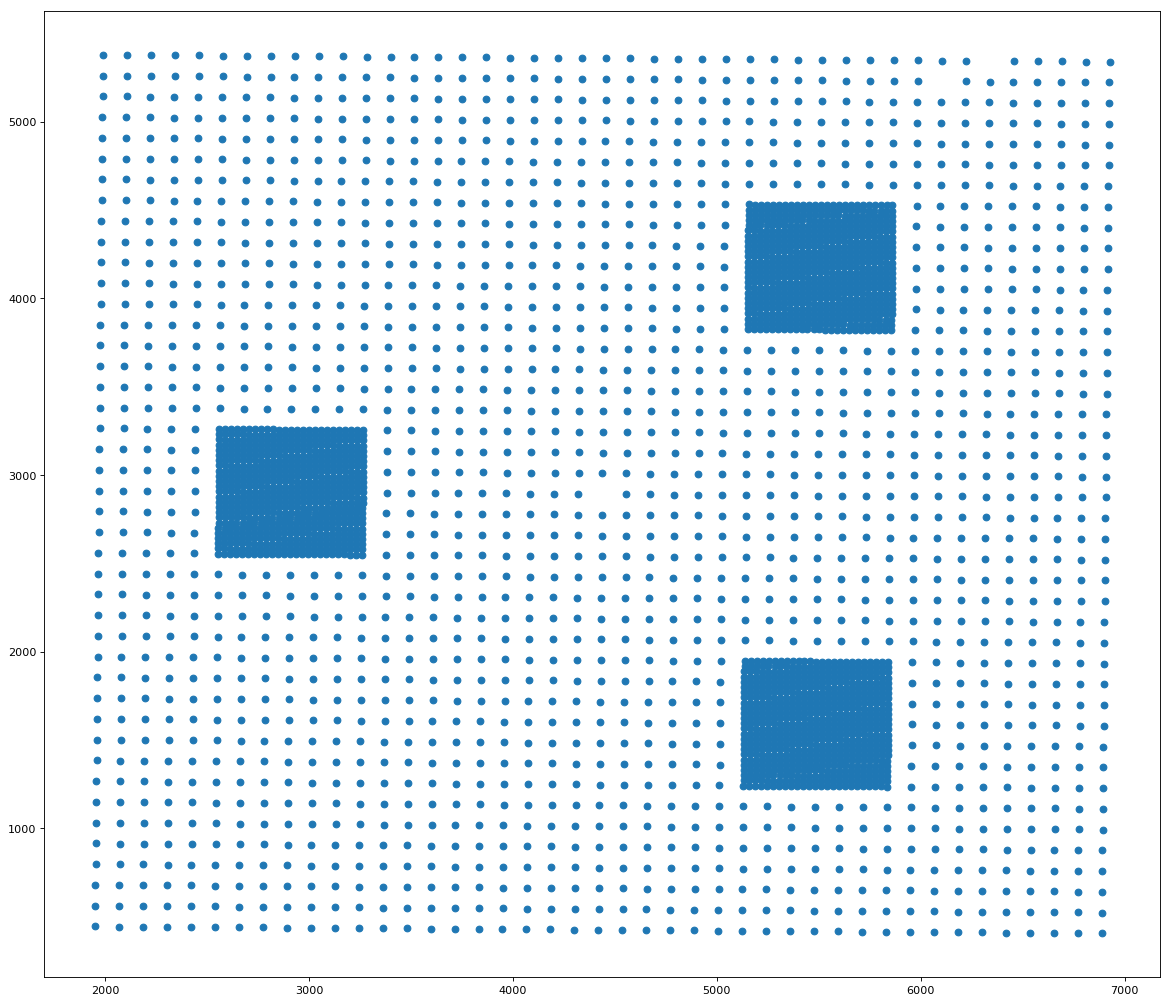

In [13]:


#do the centroiding.
reload(dist)

#you may need to do this a couple of times, to tune parameters

x,y,fx,fy,back,peak=dist.getCentroids(image,fwhm,boxsize,thresh,scale,rl,rh,sl,sh)

dist.checkCentroids(x,y,0,prefix)


# Mask calculations

The next section calculates the approximate position of the mask region, and the angle of rotation. Change the rotated parameter if 
the mask and image are rotated 90 degrees wrt each other (this is a 
difference between data taken in Taipei and Hilo. 

It then scales the centroids to mm coordinates, and applies a rotation to the mask if needed. The image spots and mask spots are then matched.



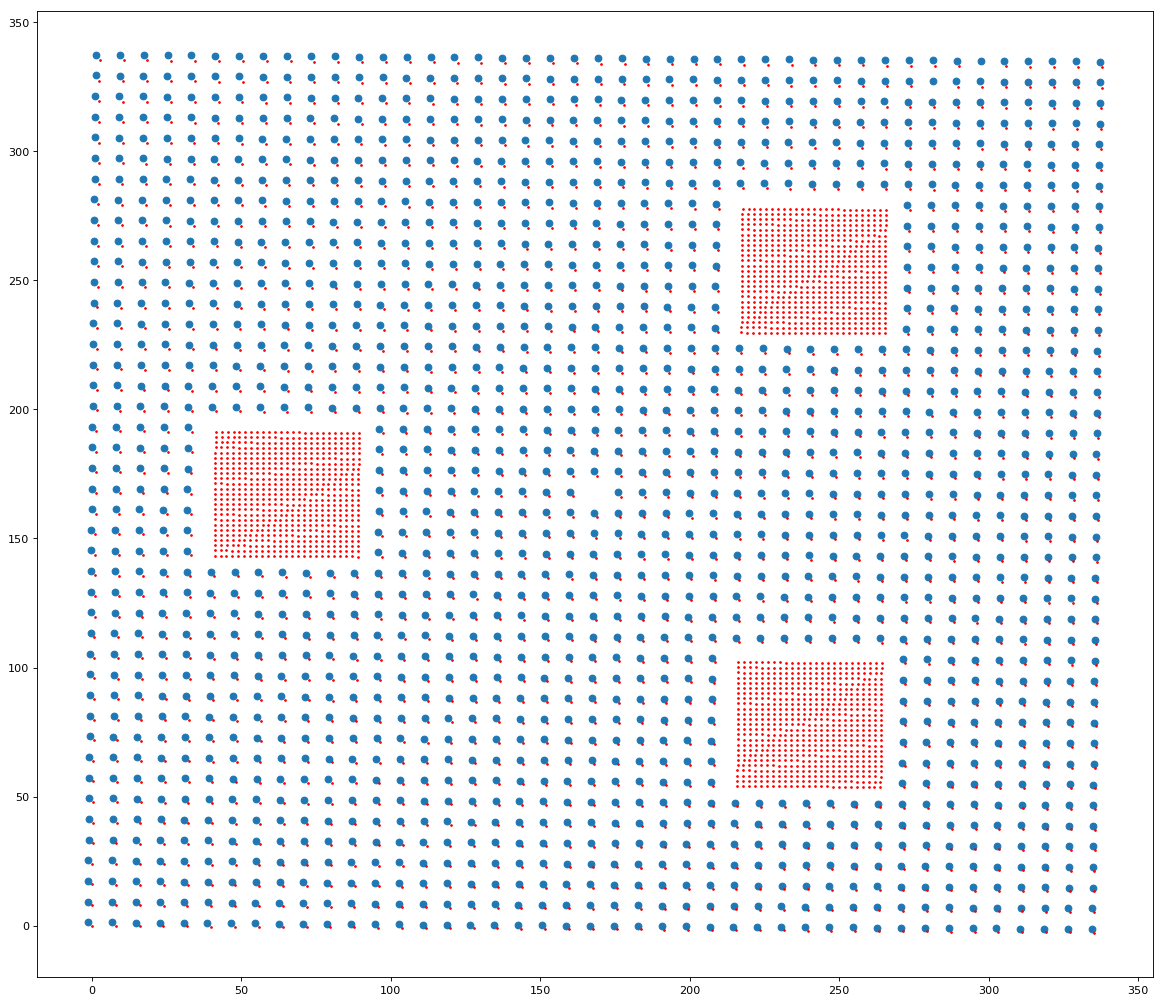

In [14]:

reload(dist)
x1,y1,angle=dist.approximateCoords(x,y,region)
includeClose=0
xx,yy=dist.maskinMM(includeClose)
xc,yc=dist.scaleCentroids(x,y,x1,y1,scale)
xx,yy=dist.scaleMask(xx,yy,angle,rotated)
xs,ys,fxs,fys,peaks=dist.matchPoints(xc,yc,xx,yy,fx,fy,peak)

dist.checkMatched(xc,yc,xx,yy,prefix)




# Image Quality Plots

Plots of FWHM values, peak values, and a rough calculation of total flux.  Set plotrange to the range you want for the colour bar (2 element numpy array); the default is min and max. 


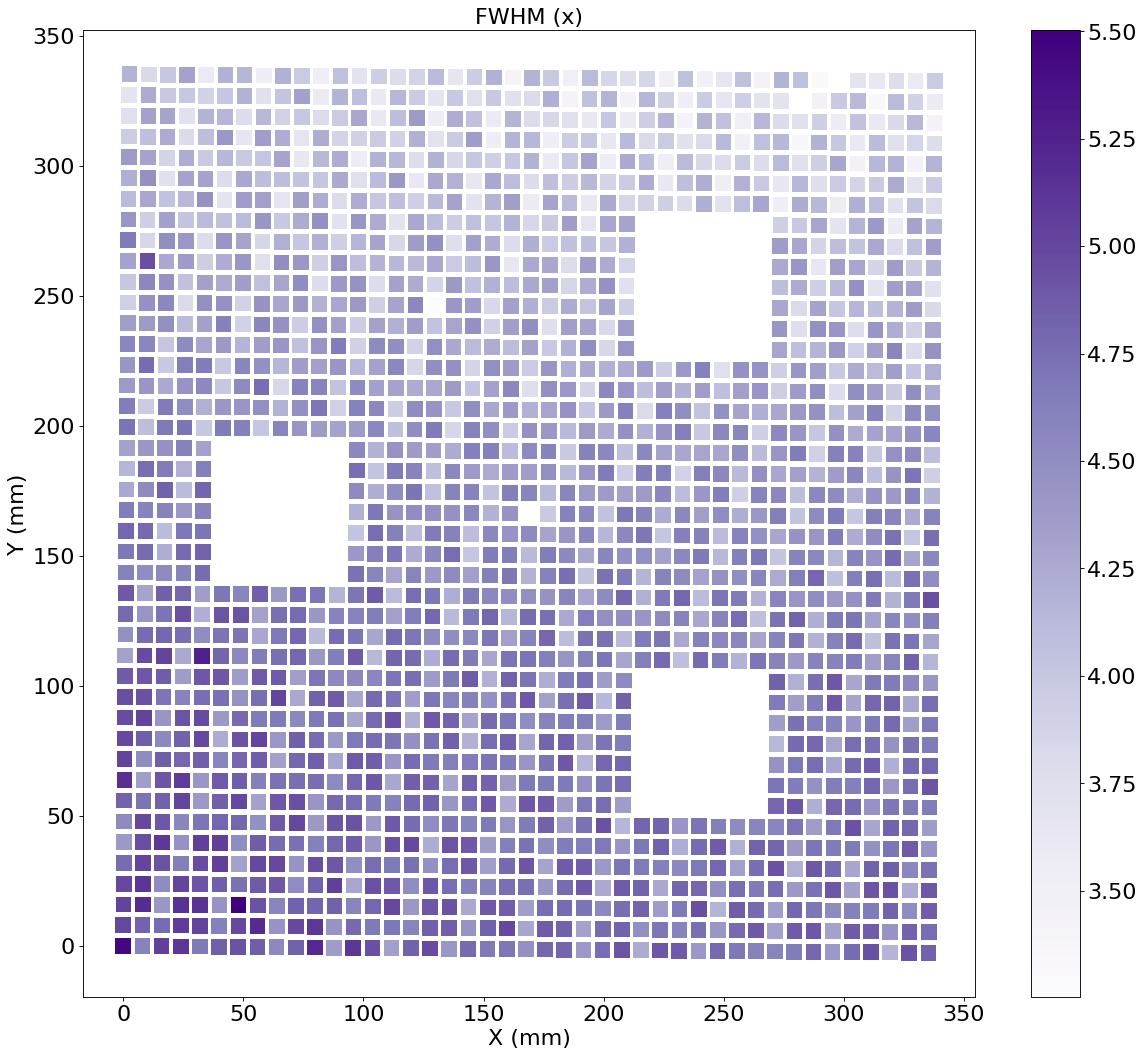

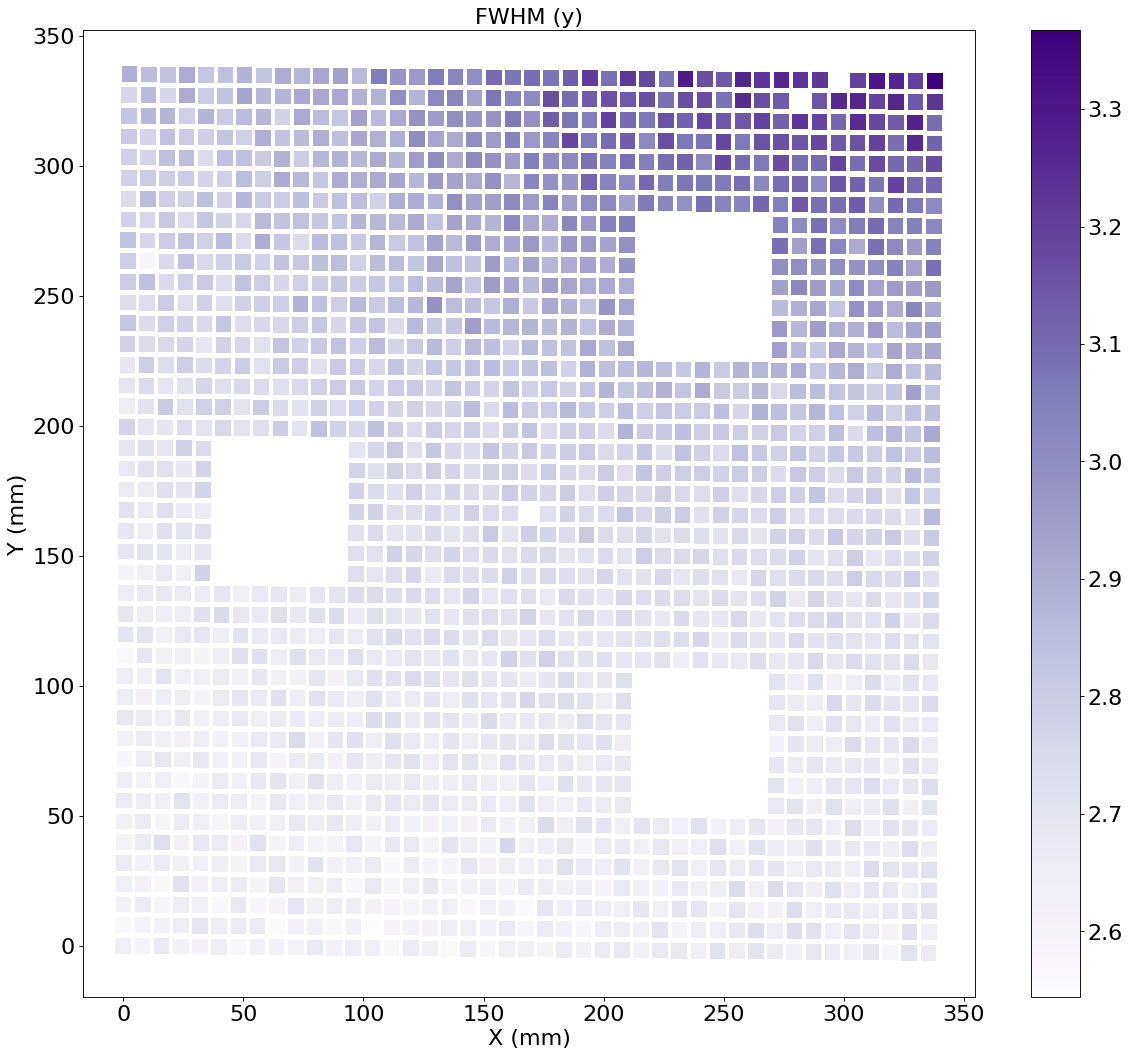

/Users/karr/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


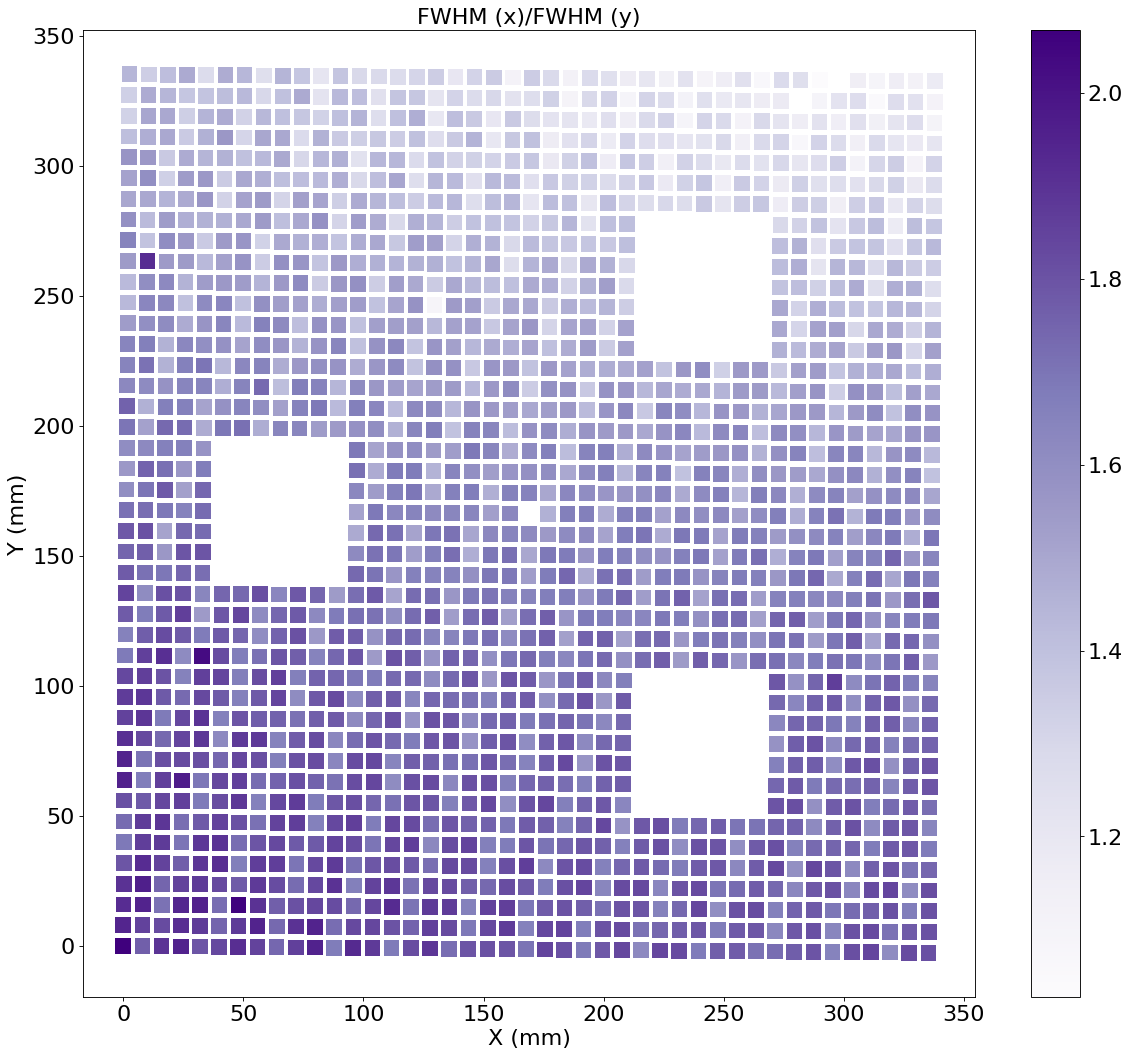

In [25]:
reload(dist)
limit=10
plotrange=None
dist.plotVal(xs,ys,fxs,limit,plotrange,"FWHM (x)",prefix,"_fwhmx")
dist.plotVal(xs,ys,fys,limit,plotrange,"FWHM (y)",prefix,"_fwhmy")
dist.plotVal(xs,ys,fxs/fys,0,plotrange,"FWHM (x)/FWHM (y)",prefix,"_fwhmxy")


# Distortion Plots

Calculations and plots for distortion of a single field. The results are plotted in three forms; quiver, colour map in mm units, colour map in units of % of the field size. 


[[  1.00226992e+00   5.25829076e-06  -3.41700716e-01]
 [ -5.25829076e-06   1.00226992e+00  -3.87667822e-01]]
sx= 1.00226992306  sy= 1.00226992306
[[  1.00000000e+00   5.24638187e-06  -3.41700716e-01]
 [ -5.24638187e-06   1.00000000e+00  -3.87667822e-01]]


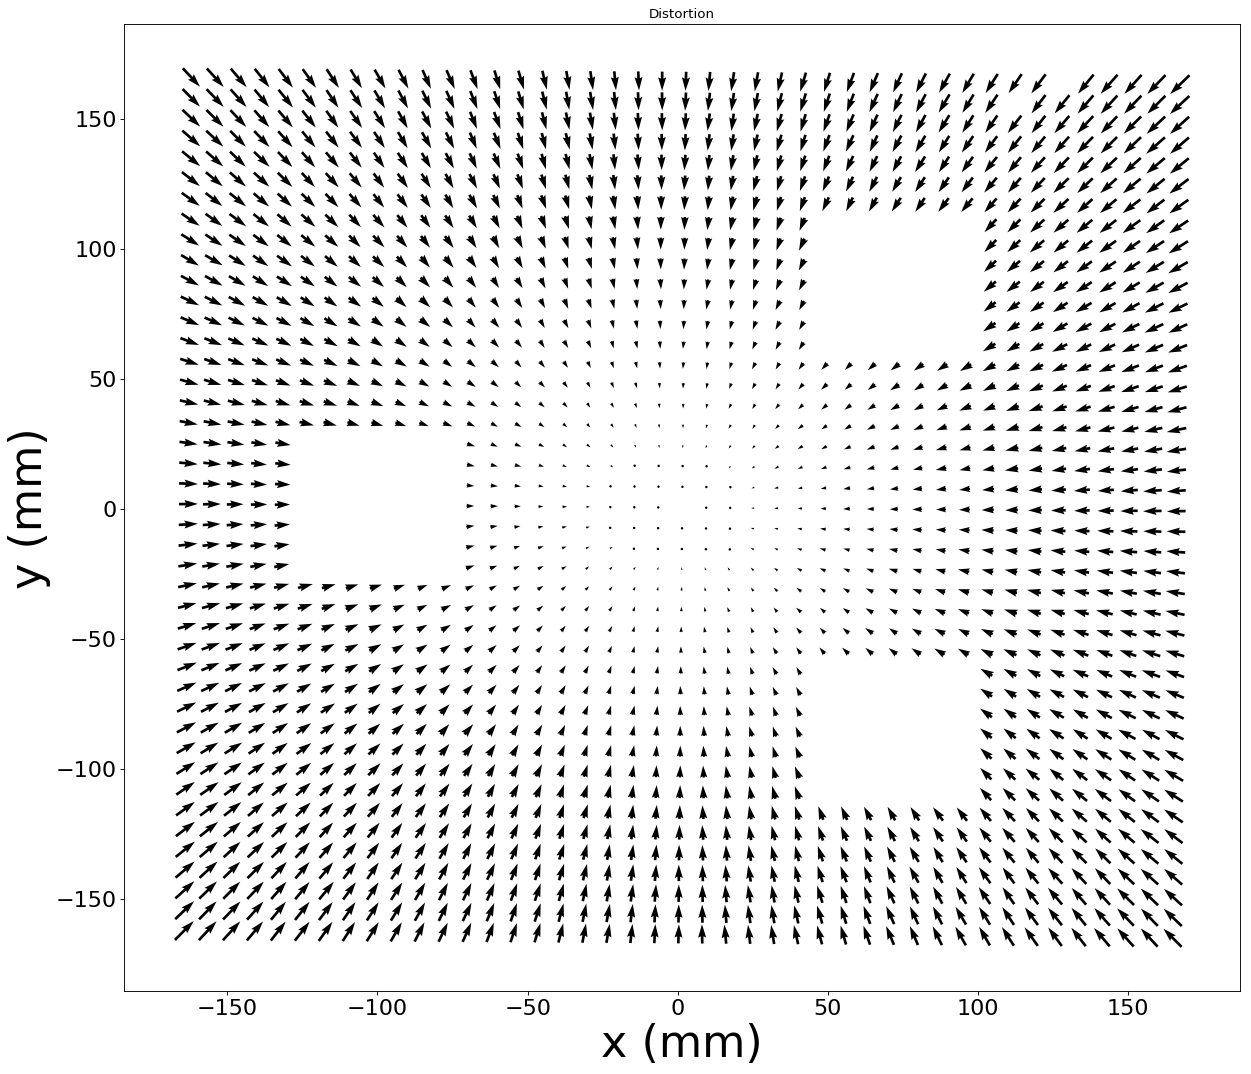

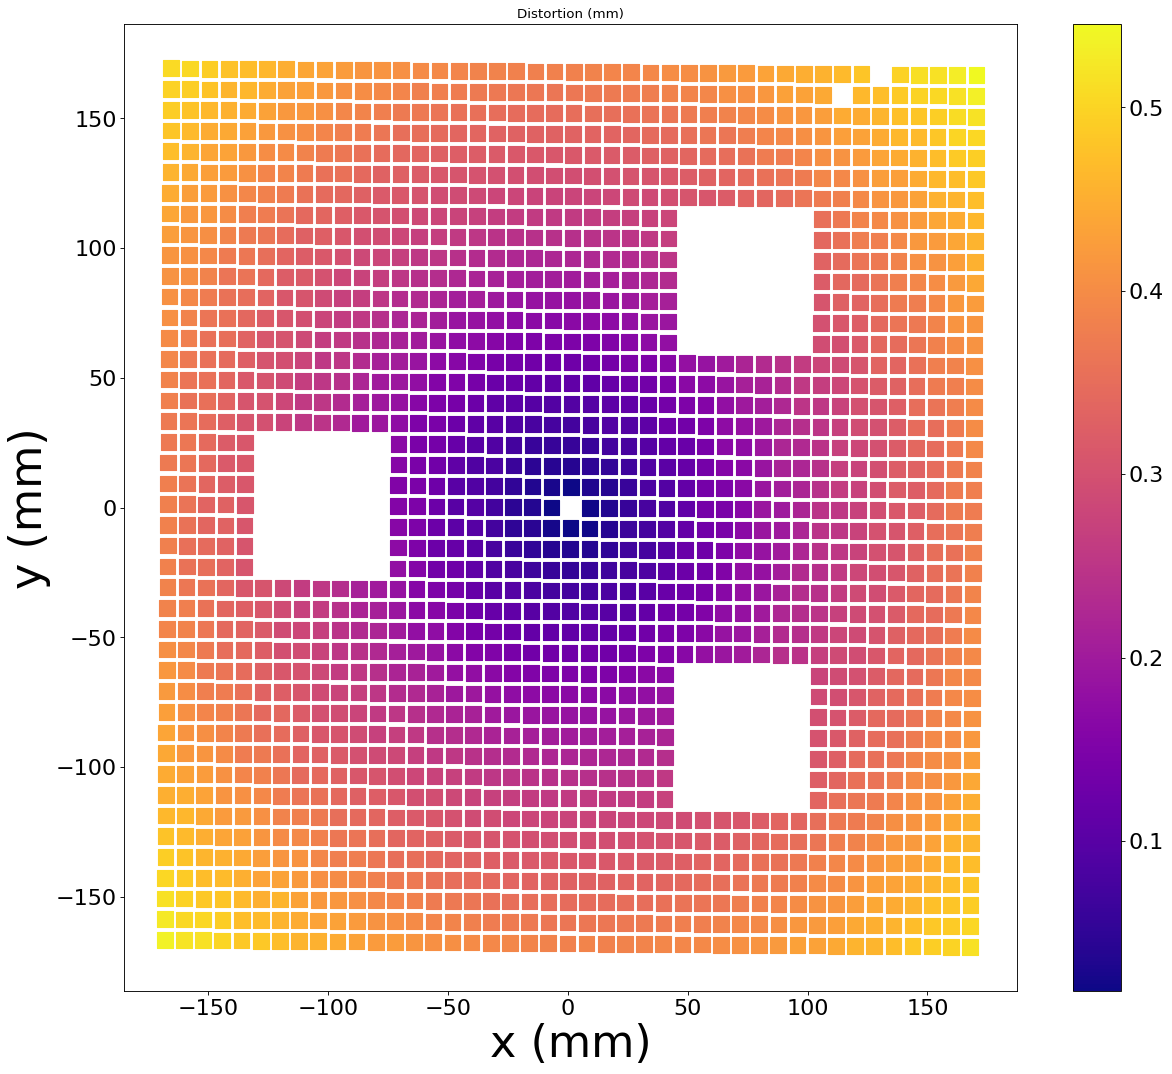

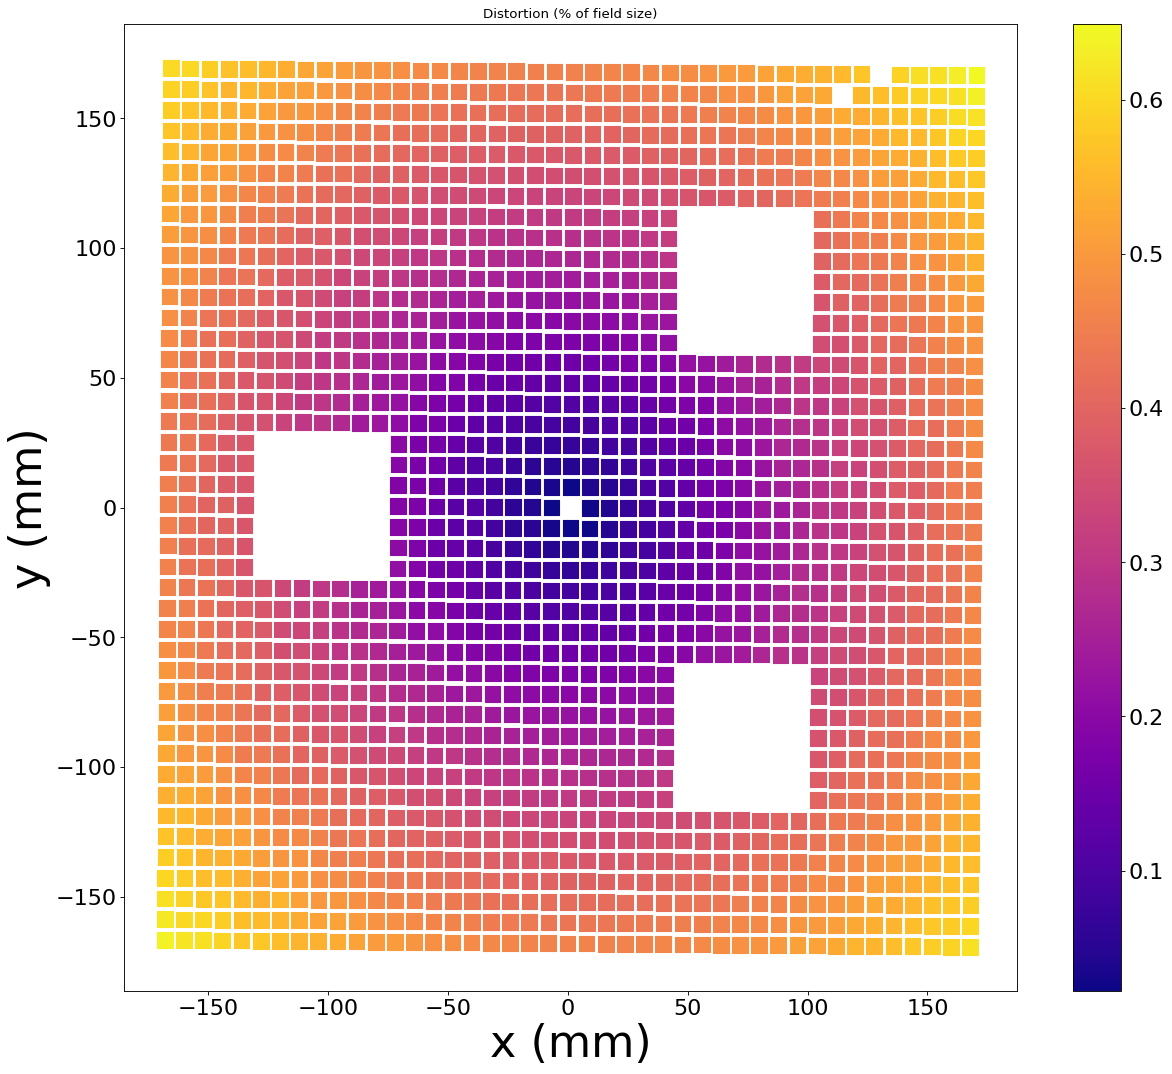

In [27]:
reload(dist)
c,c1,pts1,pts2,diffx,diffy=dist.simpleDistortion(xx,yy,xs,ys)

limit=5
dist.plotDistortion(c,c1,pts1,pts2,diffx,diffy,fxs,fys,peaks,limit,prefix)
